## EDA and Experimentation on Door Dash Dataset

### Import necessary packages and download dataset from Kaggle

In [2]:
import os
import zipfile
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi


In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import mean_squared_error, mean_absolute_error


In [162]:
# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

In [6]:
# Create the 'data' folder if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

In [164]:
# Download the dataset to the 'data' folder
api.dataset_download_files('dharun4772/doordash-eta-prediction', path='data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/dharun4772/doordash-eta-prediction


### Create a Pandas Dataframe

In [4]:
# Path to the data folder
data_folder = 'data'

csv_file_path = os.path.join(data_folder, 'historical_data.csv')

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

In [166]:
df

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,2956,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0,251,331.0
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,2956,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0,251,915.0
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,2956,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0,251,795.0
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,3630,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0,446,384.0


## Exploratory Data Analysis

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [11]:
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,196441.000000,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000
mean,2.978706,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935
std,1.524867,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000


In [12]:
min_date = pd.to_datetime(df['actual_delivery_time']).min()
max_date = pd.to_datetime(df['actual_delivery_time']).max()
print(min_date)
print(max_date)

2015-01-21 15:58:11
2015-02-19 22:45:31


In [5]:
min_date = pd.to_datetime(df['created_at']).min()
max_date = pd.to_datetime(df['created_at']).max()
print(min_date)
print(max_date)

2014-10-19 05:24:15
2015-02-18 06:00:44


In [169]:
# Check for missing values
print(df.isnull().sum())

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64


In [170]:
missing_percentage = df.isnull().sum() / len(df) * 100
print(missing_percentage)

market_id                                       0.499929
created_at                                      0.000000
actual_delivery_time                            0.003546
store_id                                        0.000000
store_primary_category                          2.411006
order_protocol                                  0.503981
total_items                                     0.000000
subtotal                                        0.000000
num_distinct_items                              0.000000
min_item_price                                  0.000000
max_item_price                                  0.000000
total_onshift_dashers                           8.236927
total_busy_dashers                              8.236927
total_outstanding_orders                        8.236927
estimated_order_place_duration                  0.000000
estimated_store_to_consumer_driving_duration    0.266426
dtype: float64


In [171]:
#Create new feature: devlivery_duration

# Convert 'created_at' and 'actual_delivery_time' to datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Calculate delivery_duration in minutes
df['delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Display the first few rows
print(df[['created_at', 'actual_delivery_time', 'delivery_duration']].head())


           created_at actual_delivery_time  delivery_duration
0 2015-02-06 22:24:17  2015-02-06 23:27:16          62.983333
1 2015-02-10 21:49:25  2015-02-10 22:56:29          67.066667
2 2015-01-22 20:39:28  2015-01-22 21:09:09          29.683333
3 2015-02-03 21:21:45  2015-02-03 22:13:00          51.250000
4 2015-02-15 02:40:36  2015-02-15 03:20:26          39.833333


In [172]:
df['delivery_duration'].describe()

count    197421.000000
mean         48.470956
std         320.493482
min           1.683333
25%          35.066667
50%          44.333333
75%          56.350000
max      141947.650000
Name: delivery_duration, dtype: float64

## View Delivery Duration Outliers

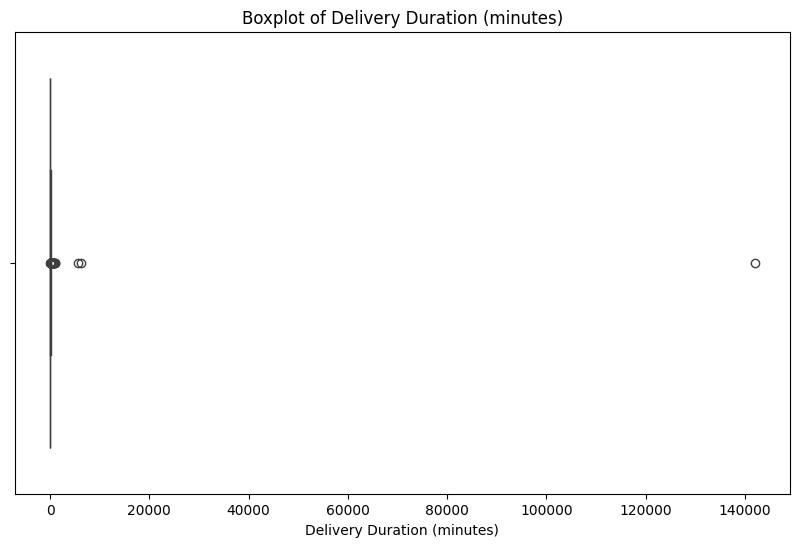

In [173]:
# Boxplot of delivery_duration to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['delivery_duration'])
plt.title('Boxplot of Delivery Duration (minutes)')
plt.xlabel('Delivery Duration (minutes)')
plt.show()

## Remove Outliers

The max delivery duration is 141947 minutes, which is way to high. We will reduce the max duration by creating an upper and lower bound.

count    197421.000000
mean         48.470956
std         320.493482
min           1.683333
25%          35.066667
50%          44.333333
75%          56.350000
max      141947.650000
Name: delivery_duration, dtype: float64
Lower Bound: 3.141666666666673, Upper Bound: 88.275


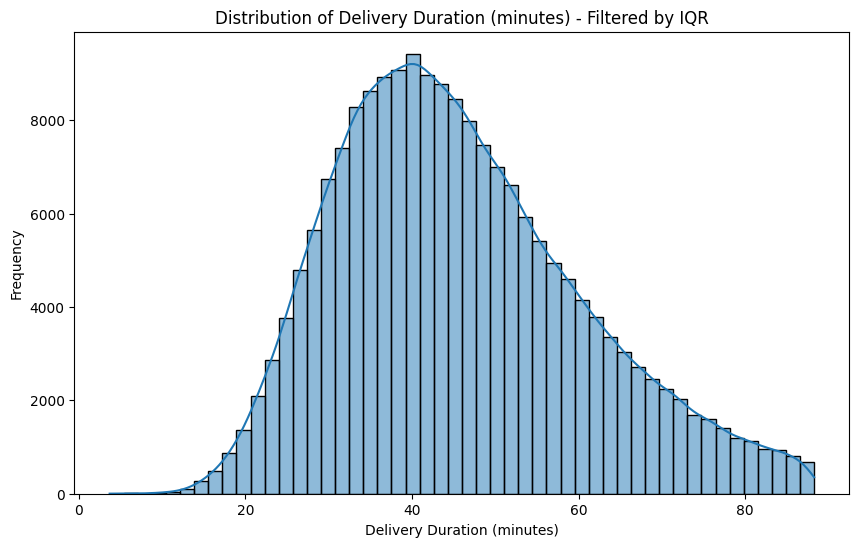

In [174]:
# Calculate summary statistics
summary_stats = df['delivery_duration'].describe()
print(summary_stats)

# Calculate the interquartile range (IQR)
Q1 = summary_stats['25%']
Q3 = summary_stats['75%']
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

# Filter out outliers
filtered_df = df[(df['delivery_duration'] >= lower_bound) & (df['delivery_duration'] <= upper_bound)]

df = filtered_df

# Plot the filtered data
plt.figure(figsize=(10, 6))
sns.histplot(df['delivery_duration'], bins=50, kde=True)
plt.title('Distribution of Delivery Duration (minutes) - Filtered by IQR')
plt.xlabel('Delivery Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

In [175]:
df['delivery_duration'].describe()

count    191143.000000
mean         45.692660
std          14.759585
min           3.716667
25%          34.766667
50%          43.716667
75%          54.850000
max          88.266667
Name: delivery_duration, dtype: float64

## View Boxplots for Numerical Columns

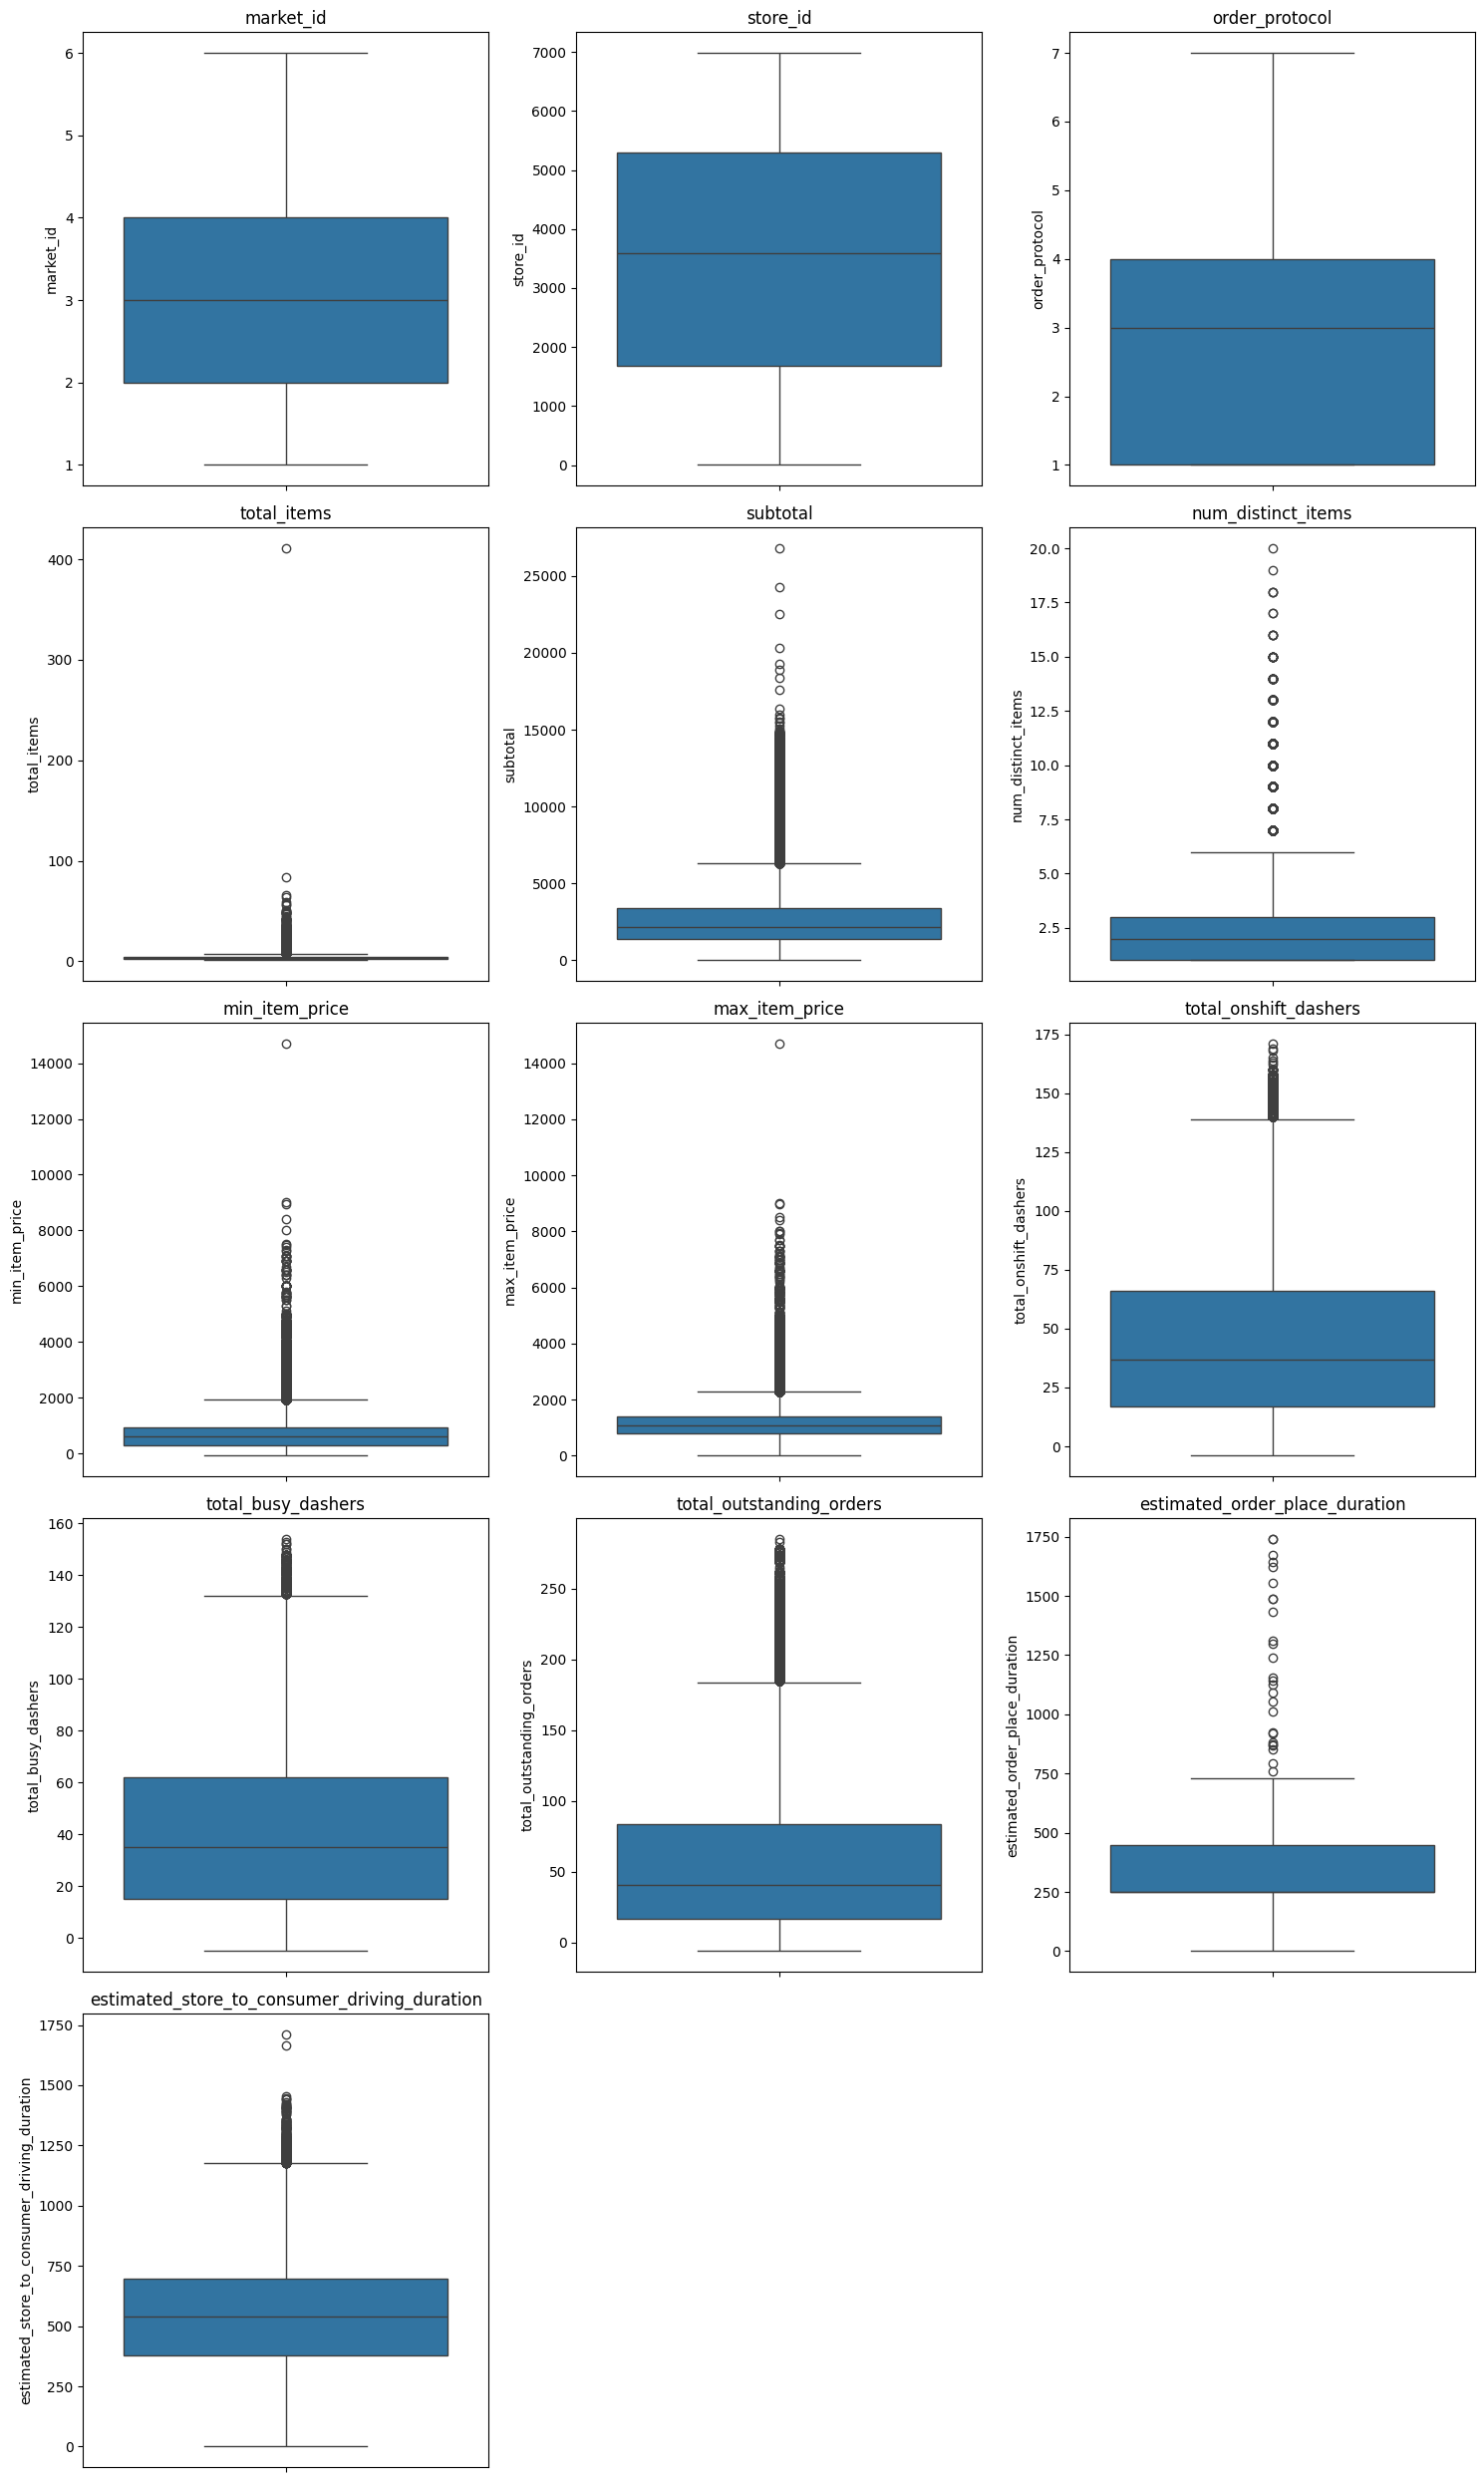

In [176]:
# Calculate number of rows needed for the plots
num_cols = 3
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols  # Ceiling division

# Visualize the data after outlier removal
# Boxplots
plt.figure(figsize=(15, num_rows * 5))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

## Set the target

In [177]:
target = 'delivery_duration'
y_train = df[target].values

print(len(y_train))

191143


In [178]:
categorical_columns = ['created_at', 'actual_delivery_time', 'store_primary_category']
numerical_columns = []

for col in df.columns:
    if col not in categorical_columns and col != target:
        numerical_columns.append(col)

print(numerical_columns)

['market_id', 'store_id', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration']


In [179]:
# Drop the target column from the DataFrame
df_features = df.drop(columns=[target])

# Convert only categorical columns to string
df_features[categorical_columns] = df_features[categorical_columns].astype(str)

# Convert DataFrame to dictionary records
train_dicts = df_features.to_dict(orient='records')

# Initialize and fit DictVectorizer
dv = DictVectorizer(sparse=True)  # Use sparse=True to return sparse matrix
X = dv.fit_transform(train_dicts)

# Split the target column into train and test sets
y = df[target].astype(float)  # Ensure the target column is in the correct format
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the results
print("Feature names:", dv.get_feature_names_out())
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Train target shape:", y_train.shape)
print("Test target shape:", y_test.shape)


Feature names: ['actual_delivery_time=2015-01-21 15:58:11'
 'actual_delivery_time=2015-01-21 16:16:34'
 'actual_delivery_time=2015-01-21 16:17:43' ... 'total_items'
 'total_onshift_dashers' 'total_outstanding_orders']
Train set shape: (152914, 348980)
Test set shape: (38229, 348980)
Train target shape: (152914,)
Test target shape: (38229,)


In [180]:
# Create a pipeline with an imputer and a linear regression model
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # or use 'median' or 'most_frequent'
    ('regressor', LinearRegression())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Calculate RMSE and MAE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Display the results
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Train target shape:", y_train.shape)
print("Test target shape:", y_test.shape)
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Train set shape: (152914, 348980)
Test set shape: (38229, 348980)
Train target shape: (152914,)
Test target shape: (38229,)
Train RMSE: 12.7811
Test RMSE: 12.8069
Train MAE: 10.1418
Test MAE: 10.1598
